# Exploratory Data Analysis

#### We are working with the data with null values in TVL, close price and market cap because we want to see since when there's registration and how it has evolved from 24-09-2023 to 21-09-2024

## Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
# Utils python file to avoid repeating some large code for the historical plots
from utils import plot_token_data

## Loading data

In [2]:
# Function to load JSON
def loadJSON(filepath):
    with open(filepath) as file:
        return json.load(file)

In [3]:
# Loading the dataframe from json
df = pd.DataFrame(loadJSON('../../data/json/tokens-final.json'))
print(df.shape)

df.head()

(76804, 8)


,Date,Token,Name,TVL,Market cap,Price,Correlation,Class
0,24-09-2023,BTC,Bitcoin,1.610619e+08,5.179683e+11,26261.44,0,4
1,25-09-2023,BTC,Bitcoin,1.546845e+08,5.117877e+11,26297.93,0,4
2,26-09-2023,BTC,Bitcoin,1.536478e+08,5.121034e+11,26212.59,0,4
3,27-09-2023,BTC,Bitcoin,1.481046e+08,5.110543e+11,26360.20,0,4
4,28-09-2023,BTC,Bitcoin,1.478454e+08,5.137136e+11,27027.20,0,4


In [4]:
# Showing basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76804 entries, 0 to 76803
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         76804 non-null  object 
 1   Token        76804 non-null  object 
 2   Name         76804 non-null  object 
 3   TVL          76804 non-null  float64
 4   Market cap   76804 non-null  float64
 5   Price        76804 non-null  float64
 6   Correlation  76804 non-null  int64  
 7   Class        76804 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 4.7+ MB


In [5]:
# Basic stats
df.describe()

,TVL,Market cap,Price,Correlation,Class
count,7.680400e+04,7.680400e+04,76804.000000,76804.000000,76804.000000
mean,3.164849e+08,7.770196e+09,458.132160,0.253489,3.663507
std,3.200450e+09,7.778576e+10,4675.565809,0.435011,0.976287
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,1.532105e+05,5.987073e+06,0.003248,0.000000,4.000000
50%,2.331298e+06,6.613152e+07,0.101600,0.000000,4.000000
75%,2.088240e+07,5.725546e+08,0.836700,1.000000,4.000000
max,6.797230e+10,1.436631e+12,73118.090000,1.000000,4.000000


## Basic graphs to understand the data

### Tokens with the highest average market cap

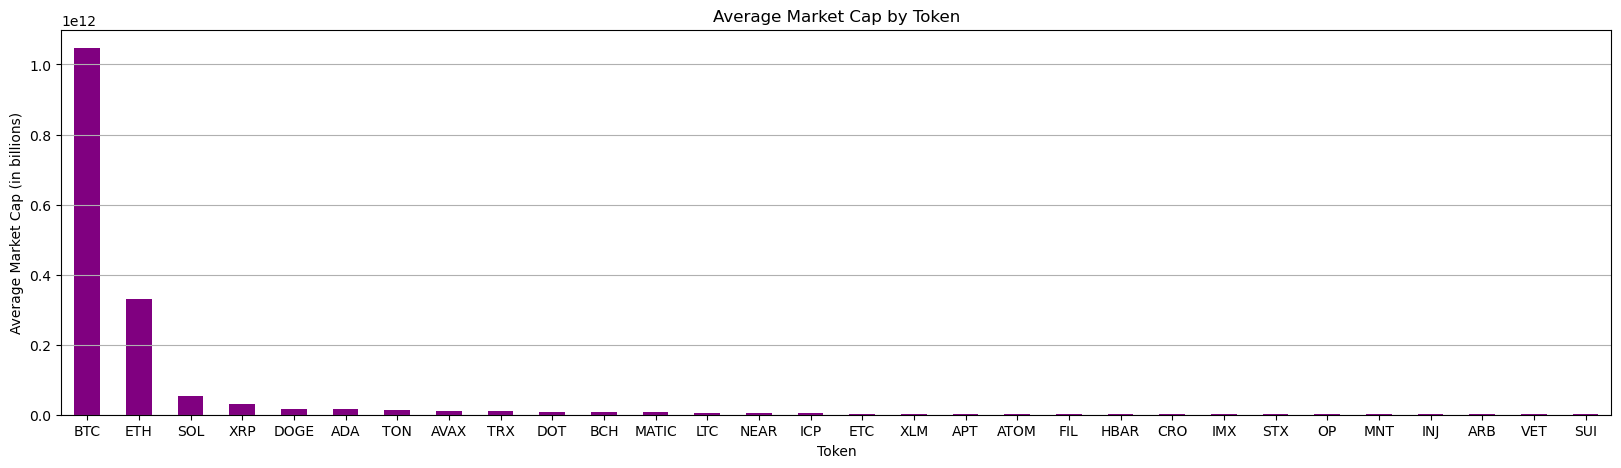

In [6]:
# Group by 'Token' and calculate average 'Market cap'
average_market_cap_desc = df.groupby('Token')['Market cap'].mean().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(20, 5))
average_market_cap_desc[:30].plot(kind='bar', color='purple')
plt.title('Average Market Cap by Token')
plt.xlabel('Token')
plt.ylabel('Average Market Cap (in billions)')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Show plot
plt.show()

## Tokens with the lowest average market cap

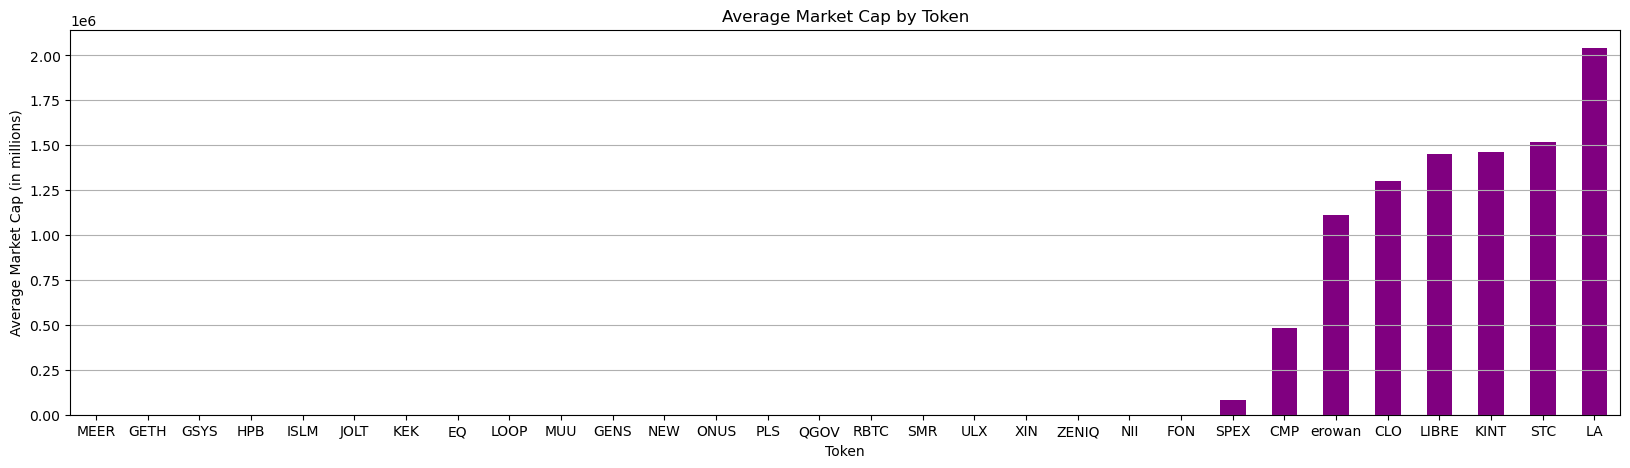

In [7]:
# Group by 'Token' and calculate average 'Market cap'
average_market_cap_asc = df.groupby('Token')['Market cap'].mean().sort_values(ascending=True)

# Plotting
plt.figure(figsize=(20, 5))
average_market_cap_asc[:30].plot(kind='bar', color='purple')
plt.title('Average Market Cap by Token')
plt.xlabel('Token')
plt.ylabel('Average Market Cap (in millions)')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Show plot
plt.show()

#### We can see that there are some tokens with average market cap in zero, we can get rid of them :)

In [8]:
# Calculate the average market cap for each token
average_market_cap = df.groupby('Token')['Market cap'].mean().reset_index()

# Identify tokens with an average market cap of 0
tokens_with_zero_market_cap = average_market_cap[average_market_cap['Market cap'] == 0]['Token']

# Filter out rows corresponding to those tokens
df = df[~df['Token'].isin(tokens_with_zero_market_cap)]

# Display the filtered DataFrame
print(df.shape)
df.head()

(68796, 8)


,Date,Token,Name,TVL,Market cap,Price,Correlation,Class
0,24-09-2023,BTC,Bitcoin,1.610619e+08,5.179683e+11,26261.44,0,4
1,25-09-2023,BTC,Bitcoin,1.546845e+08,5.117877e+11,26297.93,0,4
2,26-09-2023,BTC,Bitcoin,1.536478e+08,5.121034e+11,26212.59,0,4
3,27-09-2023,BTC,Bitcoin,1.481046e+08,5.110543e+11,26360.20,0,4
4,28-09-2023,BTC,Bitcoin,1.478454e+08,5.137136e+11,27027.20,0,4


#### We can display again!

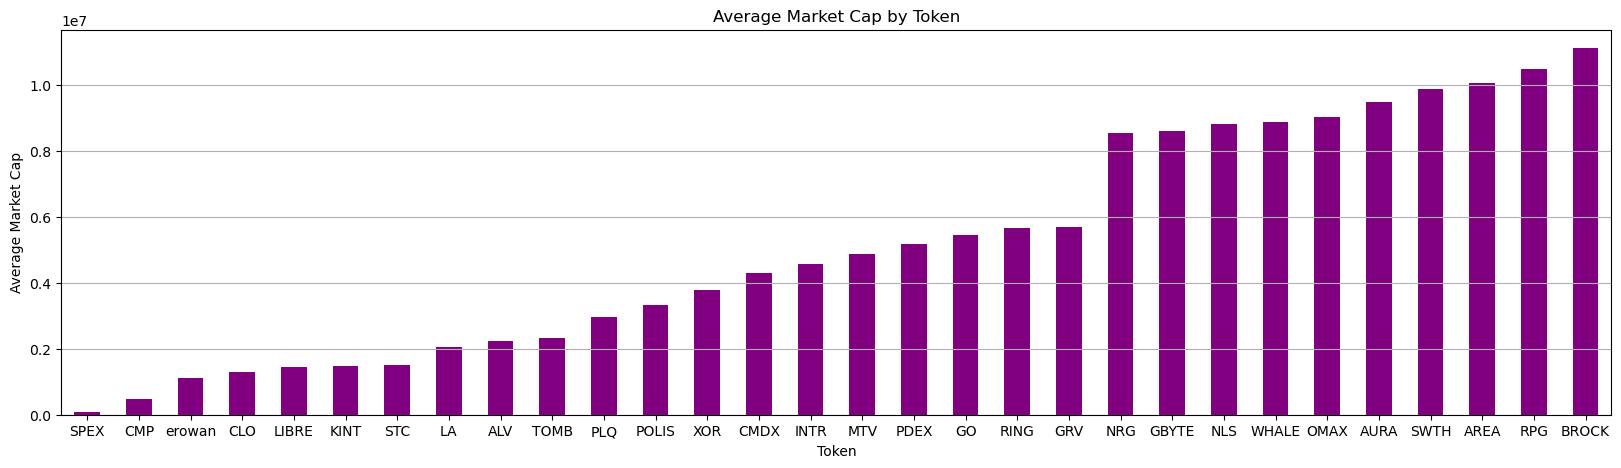

In [9]:
# Group by 'Token' and calculate average 'Market cap'
average_market_cap_asc = df.groupby('Token')['Market cap'].mean().sort_values(ascending=True)

# Plotting
plt.figure(figsize=(20, 5))
average_market_cap_asc[:30].plot(kind='bar', color='purple')
plt.title('Average Market Cap by Token')
plt.xlabel('Token')
plt.ylabel('Average Market Cap')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Show plot
plt.show()

#### It's possible to identify SPEX as the token with the lowest average market cap, but we can identify some other tokens that have a low value too...

## Instead of the average market cap, now we are focusing on the current market cap (September 21st)

In [10]:
# Convert the column 'Date' to datetime type
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Define the specific date: September 21, 2024
specific_date = pd.to_datetime('2024-09-21')
df_specific_date = df[df['Date'] == specific_date]

# Select relevant columns
df_current_market_cap = df_specific_date[['Token', 'Name', 'Market cap']].sort_values(by='Market cap', ascending=True)
    
df_current_market_cap.describe()

,Market cap
count,1.890000e+02
mean,9.623774e+09
std,9.333551e+10
min,0.000000e+00
25%,1.140357e+07
50%,9.526829e+07
75%,6.922711e+08
max,1.246476e+12


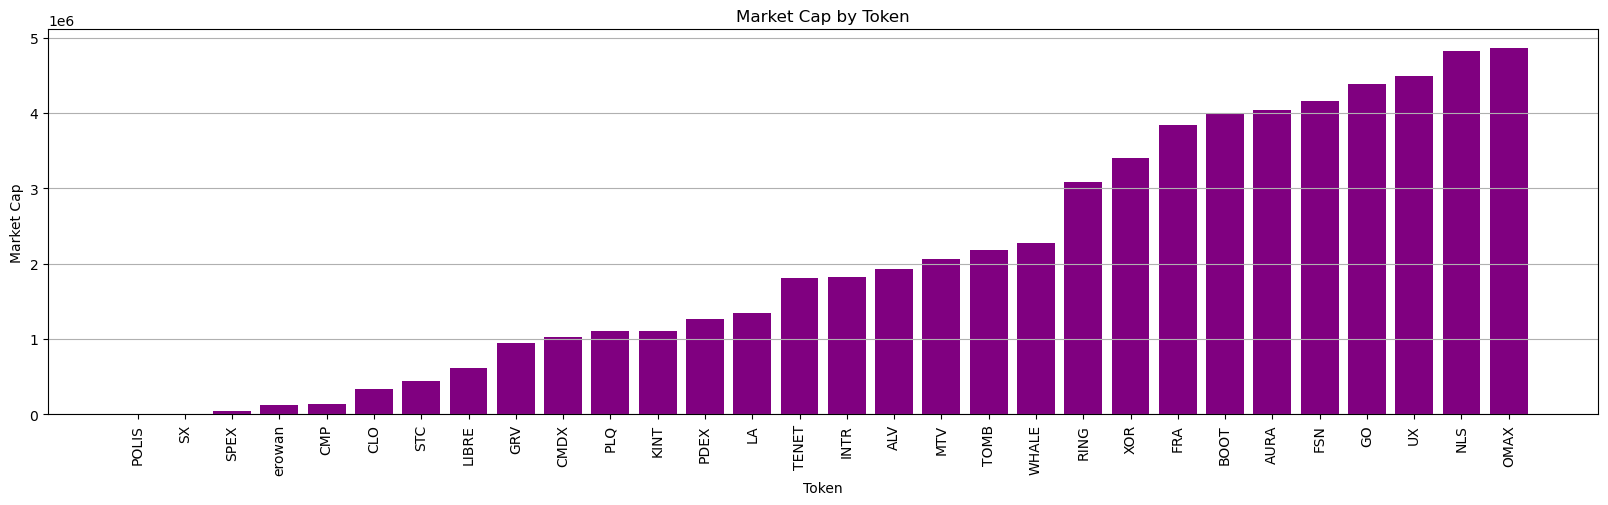

In [11]:
# Plotting
plt.figure(figsize=(20, 5))
plt.bar(df_current_market_cap[:30]['Token'], df_current_market_cap[:30]['Market cap'], color='purple')
plt.title('Market Cap by Token')
plt.xlabel('Token')
plt.ylabel('Market Cap')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Show plot
plt.show()

### All these displayed tokens do not overpass the 14 000 000 dollars in average market cap

# Average TVL, Market cap and Price by Token Class (category)

In [12]:
# Calculate class averages
average_by_class = df.groupby('Class')[['TVL', 'Market cap', 'Price']].mean().reset_index()

In [13]:
# Define the mapping dictionary
class_mapping = {
    0: 'AI',
    1: 'Gaming',
    2: 'RWA',
    3: 'Meme',
    4: 'Other'
}

# Mapping the class
average_by_class['Class'] = average_by_class['Class'].map(class_mapping)

C:\Users\andre\AppData\Local\Temp\ipykernel_10424\3593715395.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_by_class, x='Class', y='Market cap', palette='viridis')


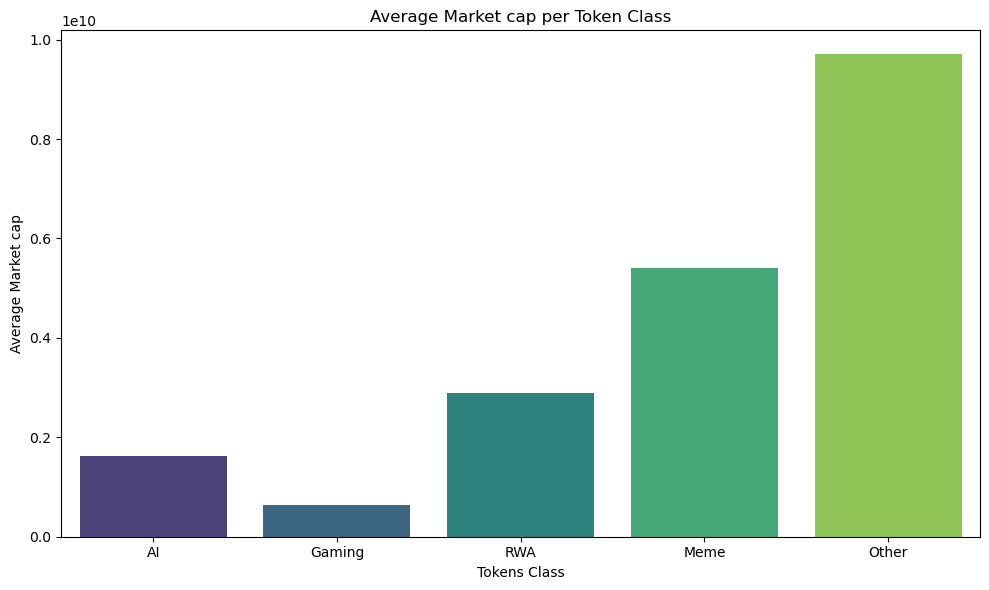

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(data=average_by_class, x='Class', y='Market cap', palette='viridis')
plt.title('Average Market cap per Token Class')
plt.xlabel('Tokens Class')
plt.ylabel('Average Market cap')
plt.tight_layout()
plt.show()

# Top 5 Tokens with Lowest Average Market Cap

In [15]:
# Order the DataFrame by date
df = df.sort_values('Date')

In [16]:
# Defining the line that represents the Bitcoin halving date in 2024 (April 20th)
vertical_line_date = pd.to_datetime('2024-04-20')

In [17]:
# Calculate the average Market Cap per Token
top5_low_market_cap_tokens = average_market_cap_asc.head(5).index.tolist()
print("Top 5 Tokens por Market Cap Promedio:", top5_low_market_cap_tokens)

Top 5 Tokens por Market Cap Promedio: ['SPEX', 'CMP', 'erowan', 'CLO', 'LIBRE']


In [18]:
# Filter the DataFrame to include only the top 5 tokens
df_top5_low_market_cap = df[df['Token'].isin(top5_low_market_cap_tokens)]

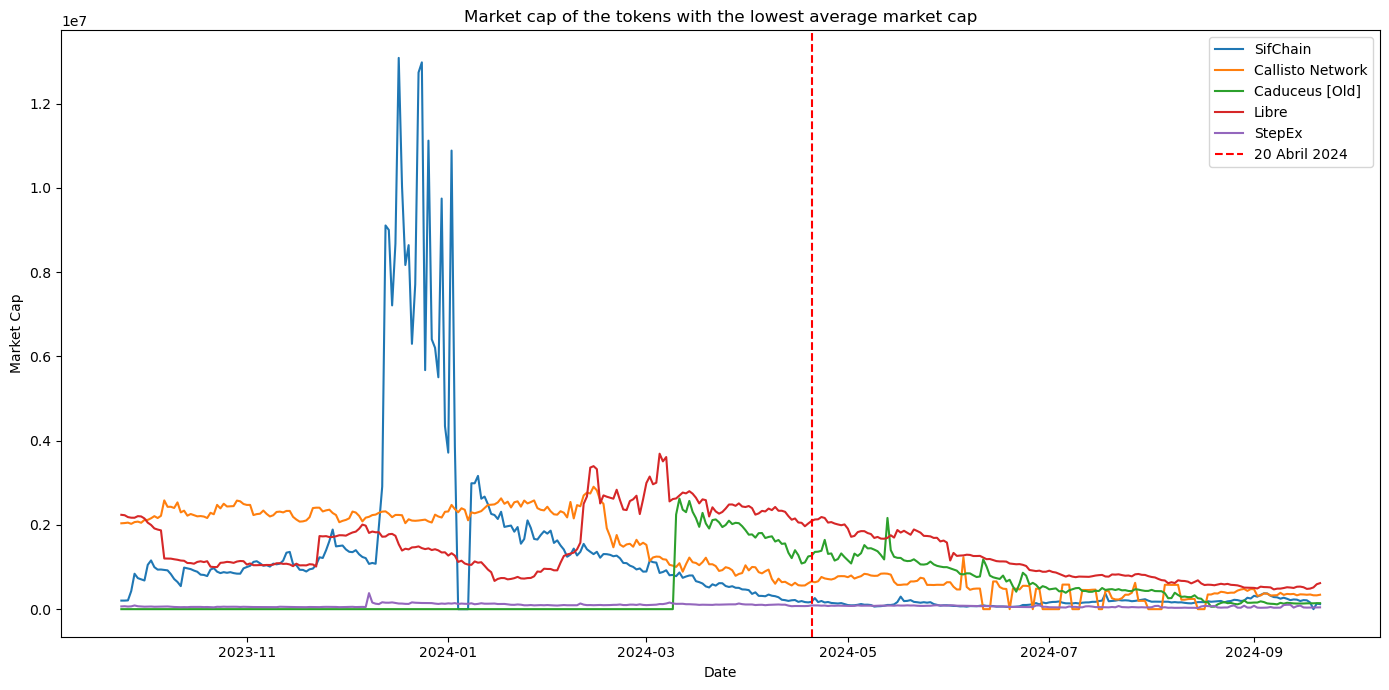

In [19]:
# Create Market Cap Time Series chart for Top 5 Tokens
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_top5_low_market_cap, x='Date', y='Market cap', hue='Name')

# Add vertical dotted line
plt.axvline(x=vertical_line_date, linestyle='--', color='red')

# Configure titles and labels
plt.title('Market cap of the tokens with the lowest average market cap')
plt.xlabel('Date')
plt.ylabel('Market Cap')

# Adjust the legend to include the vertical line
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='red', linestyle='--'))
labels.append('20 Abril 2024')
plt.legend(handles=handles, labels=labels)

plt.tight_layout()
plt.show()

#### It's possible to identify that the market cap of these tokens was decaying since march 2024. After the halving, they suffered a minimum increase but continued towards lower values.

#### We can also check their historical close prices

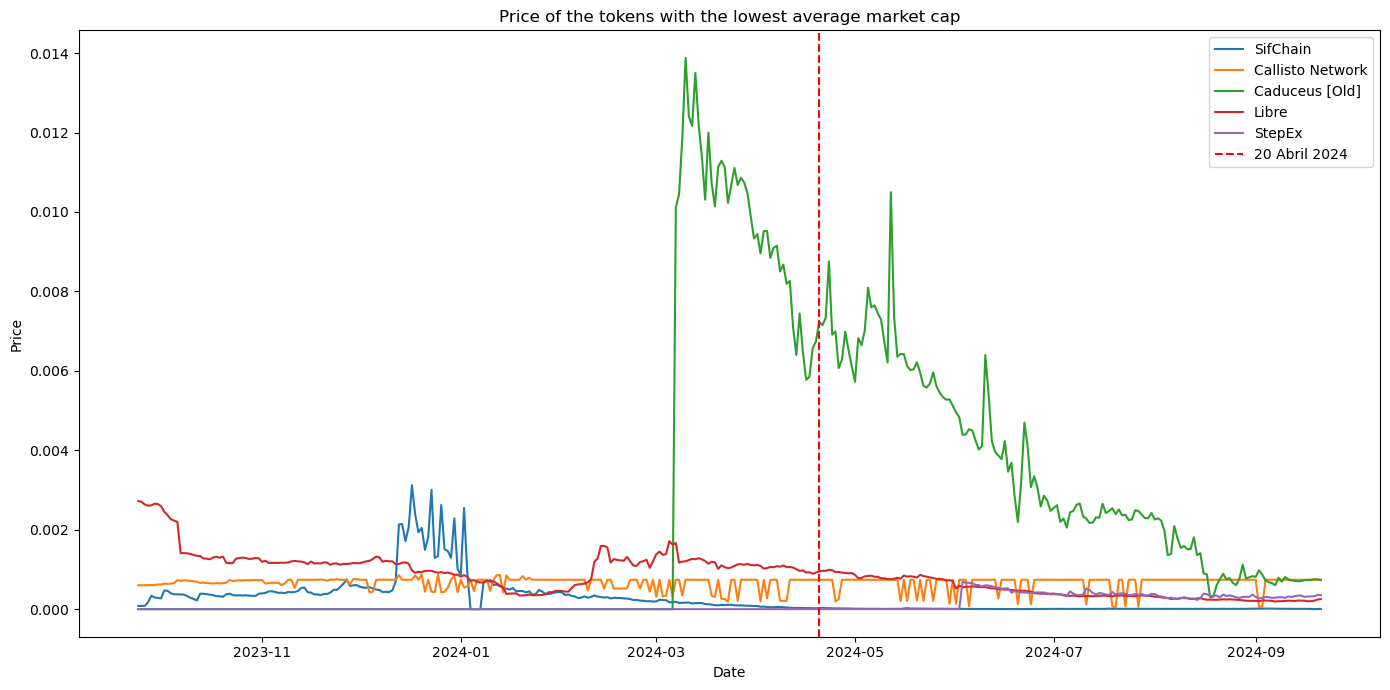

In [20]:
# Create the Price Time Series chart for the Top 5 Tokens
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_top5_low_market_cap, x='Date', y='Price', hue='Name')

# Add vertical dotted line
plt.axvline(x=vertical_line_date, linestyle='--', color='red')

# Configure titles and labels
plt.title('Price of the tokens with the lowest average market cap')
plt.xlabel('Date')
plt.ylabel('Price')

# Adjust the legend to include the vertical line
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='red', linestyle='--'))
labels.append('20 Abril 2024')
plt.legend(handles=handles, labels=labels)

plt.tight_layout()
plt.show()

#### A we can see, the prices and the market cap are higly correlated

# Top 5 Tokens with Highest Average Market Cap

In [21]:
# Now get the top 5 with the highest average market cap
top5_high_market_cap_tokens = average_market_cap_asc.tail(5).index.tolist()
print("Top 5 Tokens por Market Cap Promedio:", top5_high_market_cap_tokens)

Top 5 Tokens por Market Cap Promedio: ['DOGE', 'XRP', 'SOL', 'ETH', 'BTC']


In [22]:
# Filter the DataFrame to include only the top 5 tokens
df_top5_high_market_cap = df[df['Token'].isin(top5_high_market_cap_tokens)]

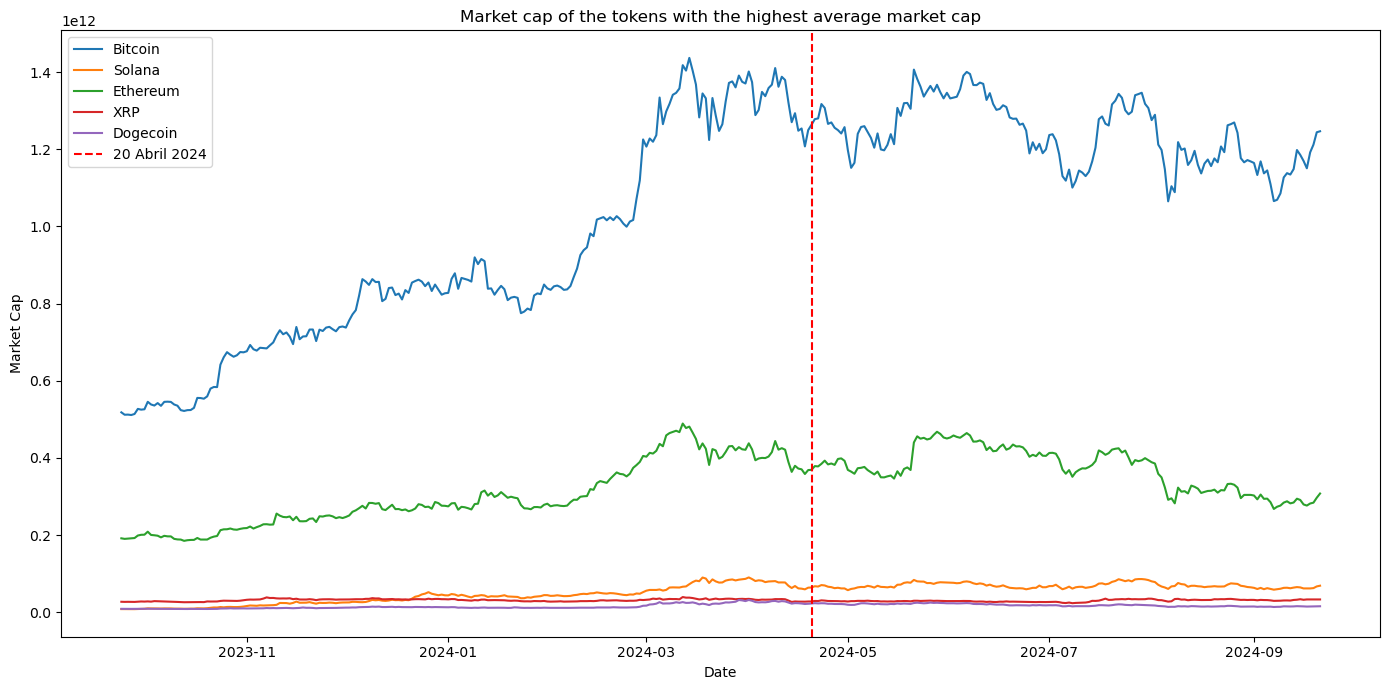

In [23]:
# Create Market Cap Time Series chart for Top 5 Tokens
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_top5_high_market_cap, x='Date', y='Market cap', hue='Name')

# Add vertical dotted line
plt.axvline(x=vertical_line_date, linestyle='--', color='red')

# Configure titles and labels
plt.title('Market cap of the tokens with the highest average market cap')
plt.xlabel('Date')
plt.ylabel('Market Cap')

# Adjust the legend to include the vertical line
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='red', linestyle='--'))
labels.append('20 Abril 2024')
plt.legend(handles=handles, labels=labels)

plt.tight_layout()
plt.show()

#### In this case, it's obvious that Bitcoin has the highest. Dogecoin seems way too little, but we have to remember that the graph it's scaled by 1e12 (1 000 000 000 000). To confirm this, let's have a quick look at Dogecoin TVL, close price and market cap (spoiler for later)

#### In order to hide the big amount of code and avoid being redundant in all these big charts, we've created a dedicated function inside *utils.py*

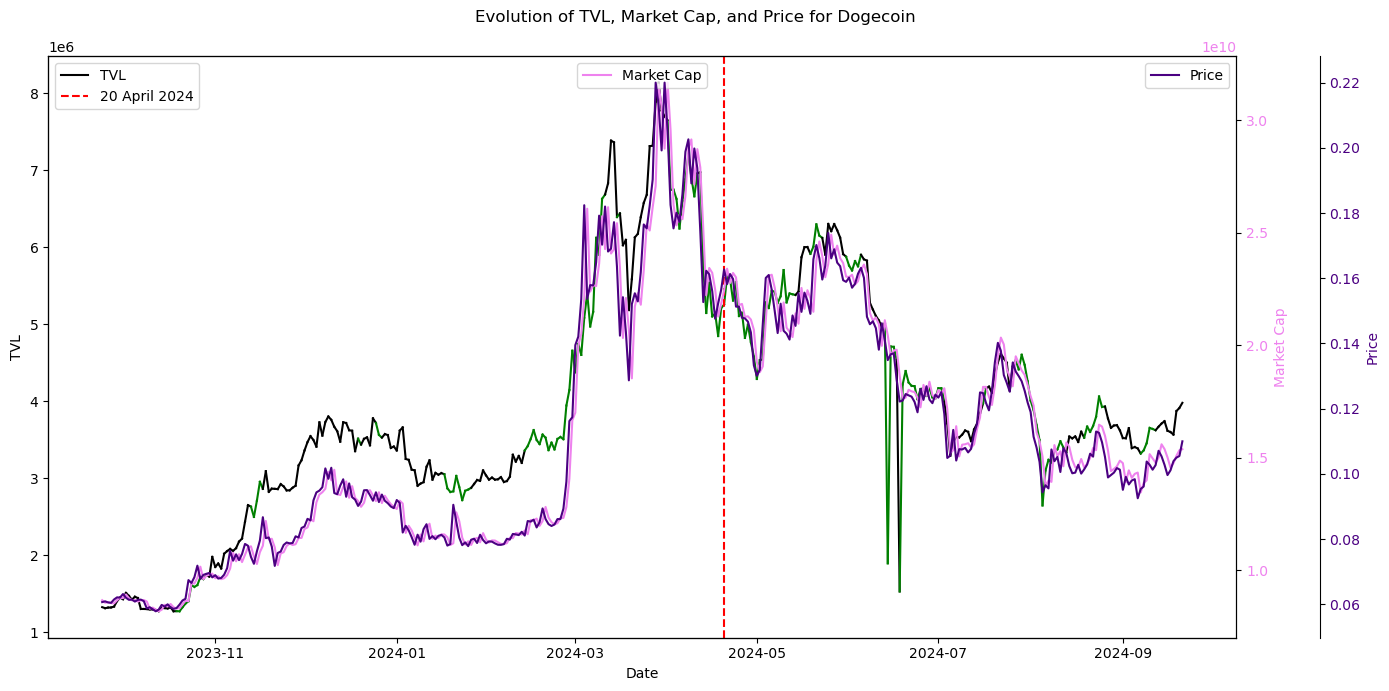

In [24]:
plot_token_data(df, 'Dogecoin', pd.to_datetime('2024-04-20'))

#### As wee can see, the historical market cap of Dogecoin is not that little...

#### (We are going to explain this plot later)

#### It's also possible to check their prices

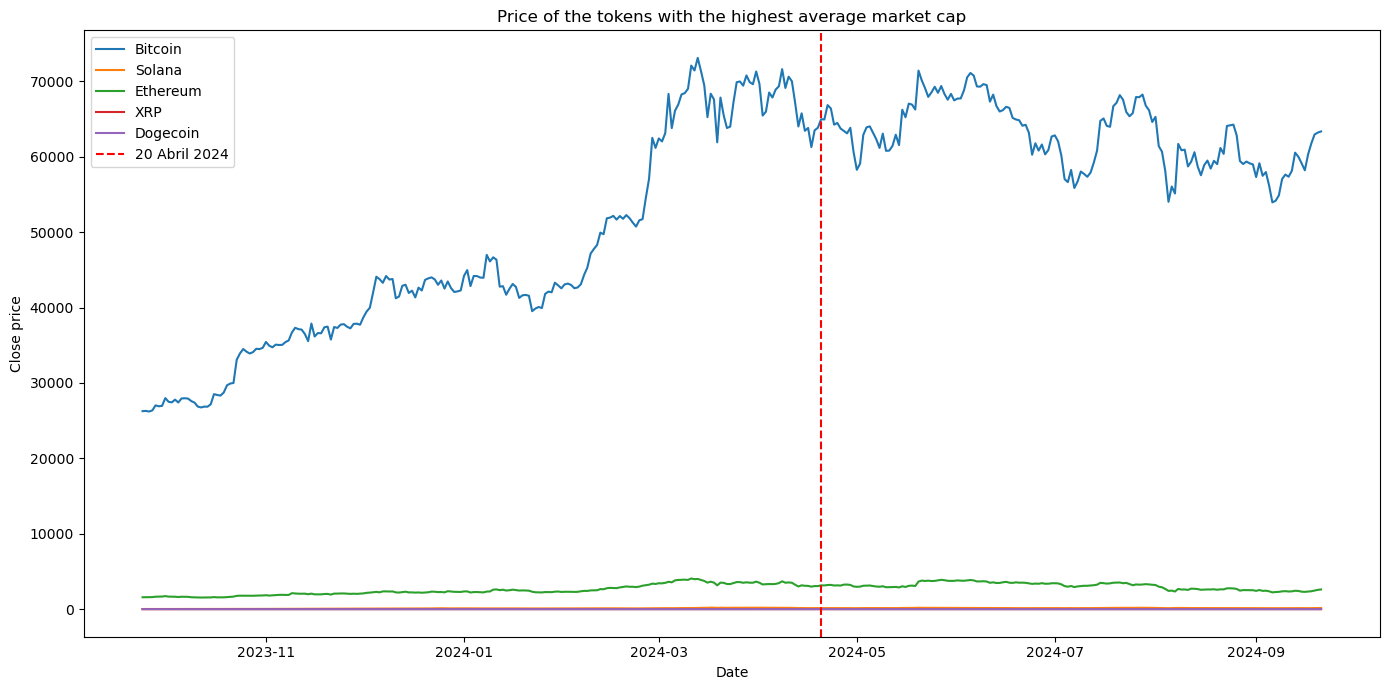

In [25]:
# Create the Price Time Series chart for the Top 5 Tokens
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_top5_high_market_cap, x='Date', y='Price', hue='Name')

# Add vertical dotted line
plt.axvline(x=vertical_line_date, linestyle='--', color='red')

# Configure titles and labels
plt.title('Price of the tokens with the highest average market cap')
plt.xlabel('Date')
plt.ylabel('Close price')

# Adjust the legend to include the vertical line
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='red', linestyle='--'))
labels.append('20 Abril 2024')
plt.legend(handles=handles, labels=labels)

plt.tight_layout()
plt.show()

# Correlation Heat Map for Bitcoin

In [26]:
name_token = 'MicroVisionChain'

# Filter the DataFrame to include only the records of the selected token
df_filtered = df[df['Name'] == name_token]

In [27]:
# Select numerical columns for correlation
numeric_columns = ['TVL', 'Market cap', 'Price', 'Correlation']

In [28]:
# Delete rows with null values in selected columns
df_numeric = df_filtered[numeric_columns].dropna()

In [29]:
# Calculate the correlation matrix
corr_matrix = df_numeric.corr()
print(f"correlation matrix for {name_token}:")
print(corr_matrix)

correlation matrix for MicroVisionChain:
                  TVL  Market cap     Price  Correlation
TVL          1.000000    0.903976  0.819105    -0.159773
Market cap   0.903976    1.000000  0.980161    -0.105262
Price        0.819105    0.980161  1.000000    -0.129840
Correlation -0.159773   -0.105262 -0.129840     1.000000


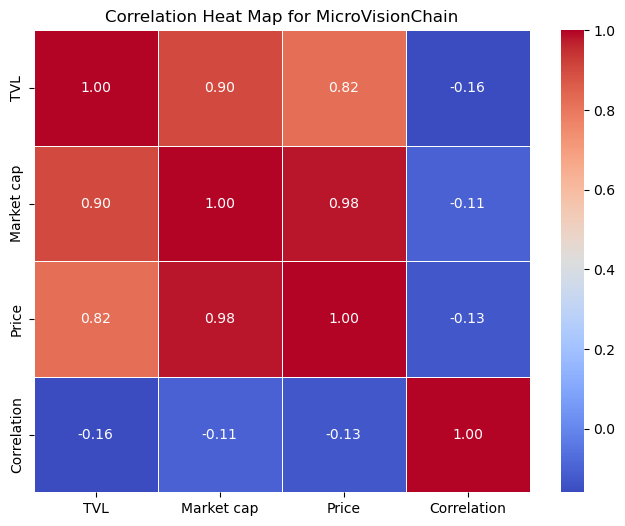

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title(f'Correlation Heat Map for {name_token}')
plt.show()

#### The correlation we've been talking about can also be visualized through a correlation heat map

## Evolution of LTV, Market Cap and Price

### Checking the ones from the average market cap

- Lowest market cap

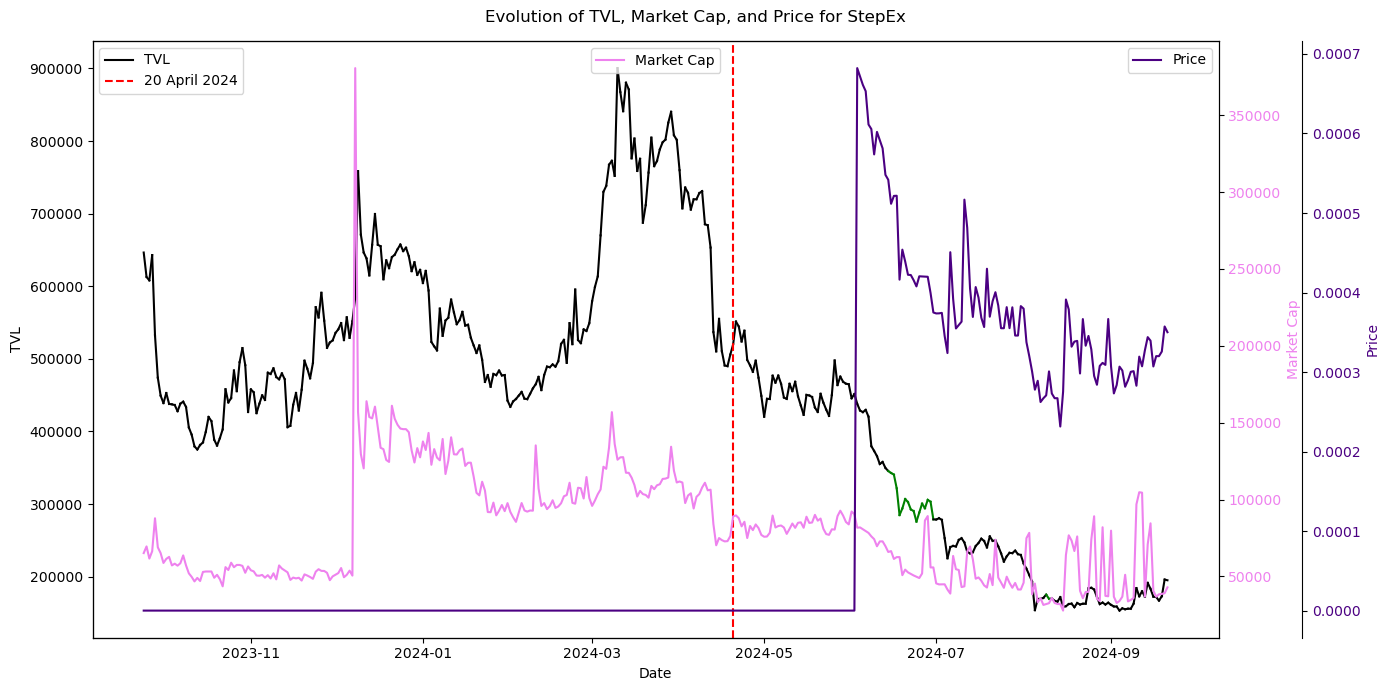

In [31]:
plot_token_data(df, 'StepEx', pd.to_datetime('2024-04-20'))

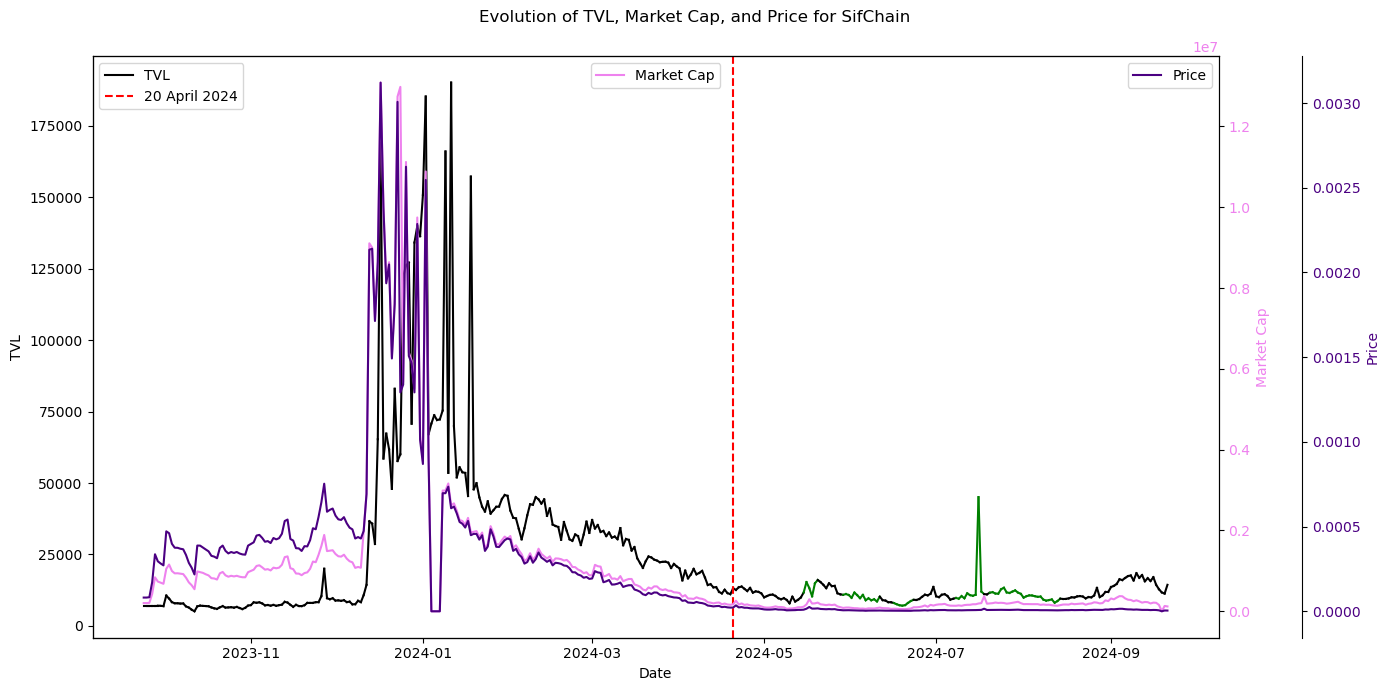

In [32]:
plot_token_data(df, 'SifChain', pd.to_datetime('2024-04-20'))

- Bitcoin (the highest average market cap)

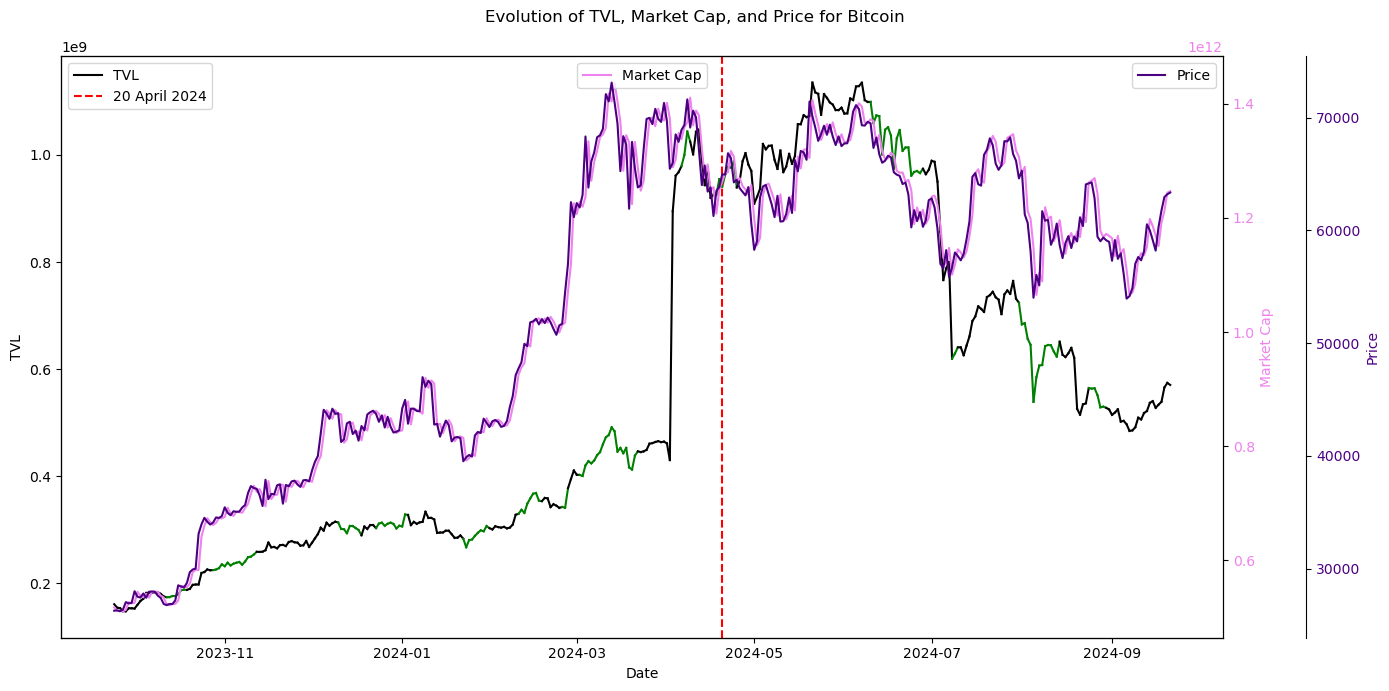

In [33]:
plot_token_data(df, 'Bitcoin', pd.to_datetime('2024-04-20'))

- Solana

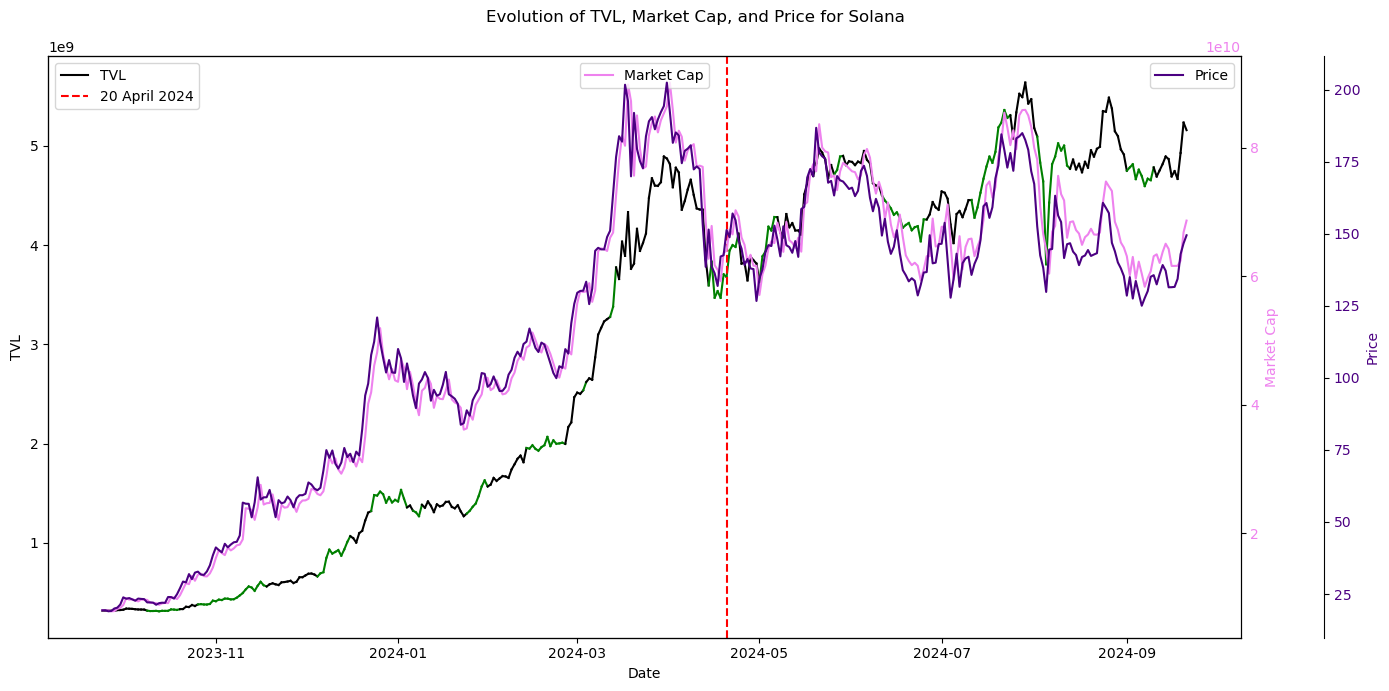

In [34]:
plot_token_data(df, 'Solana', pd.to_datetime('2024-04-20'))

- Other tokens

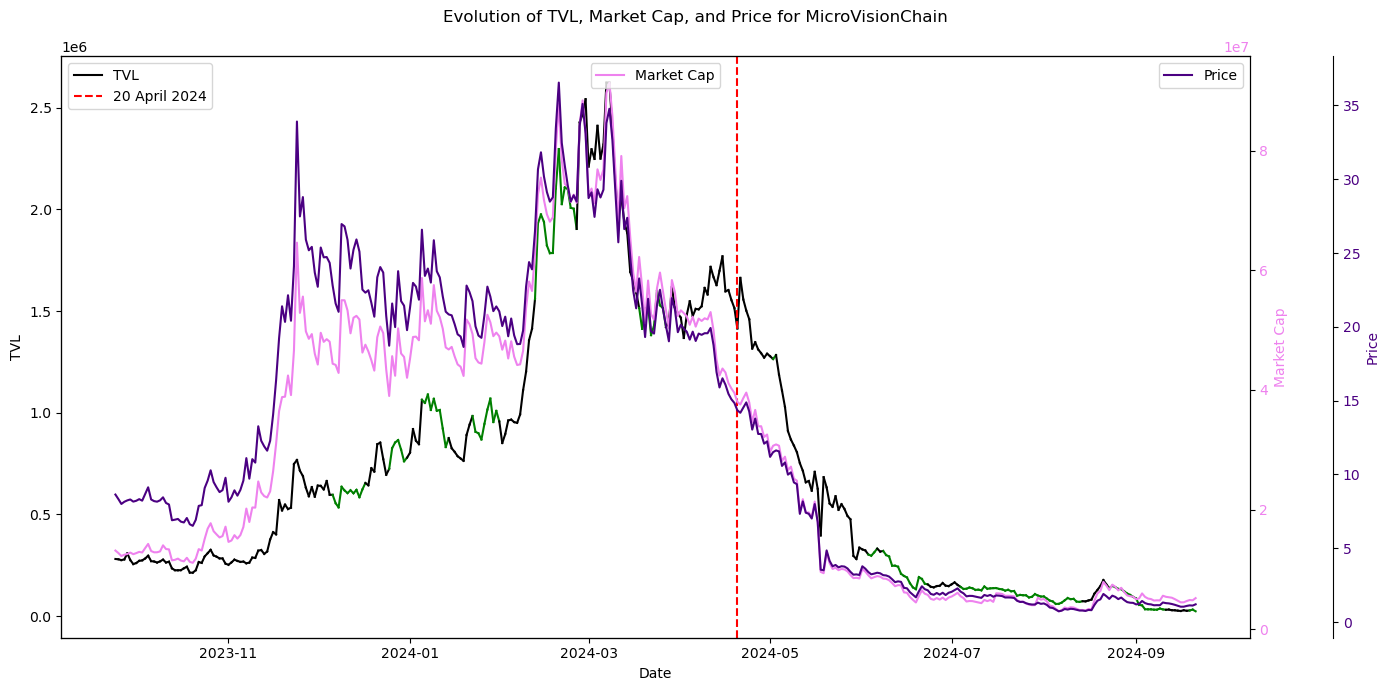

In [35]:
plot_token_data(df, 'MicroVisionChain', pd.to_datetime('2024-04-20'))

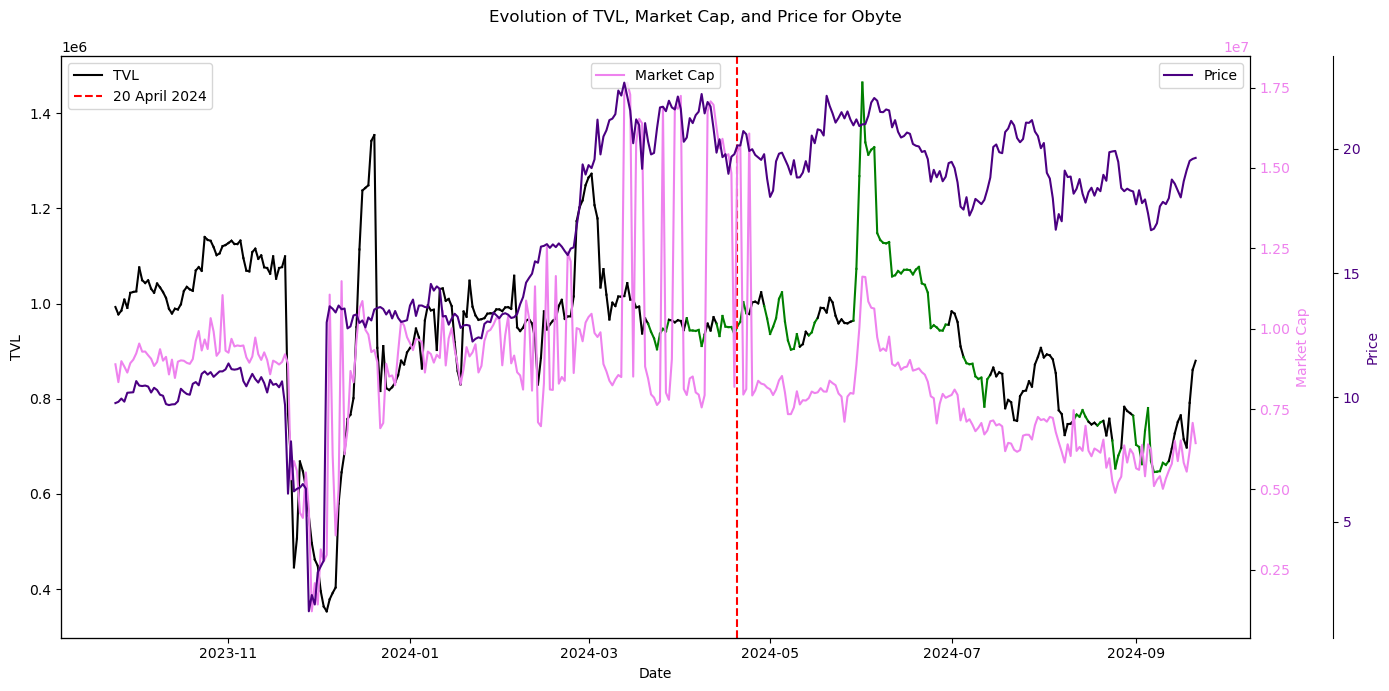

In [36]:
plot_token_data(df, 'Obyte', pd.to_datetime('2024-04-20'))

## Extra plots

In [37]:
# Calculate the historical average of the market cap per token
average_market_cap = df.groupby('Token')['Market cap'].mean().reset_index()

# Calculate the 25% quartile of the average market cap
cuartil_25_market_cap = average_market_cap['Market cap'].quantile(0.25)

# Filter cryptocurrencies whose average market cap is below the quartile 25%.
low_market_cap_tokens = average_market_cap[average_market_cap['Market cap'] < cuartil_25_market_cap]['Token']

# Filter the original DataFrame to keep only the filtered tokens
filtered_df = df[df['Token'].isin(low_market_cap_tokens)]

In [38]:
# Group by date and calculate the average of the metrics
average_data = filtered_df.groupby('Date').agg({'Price': 'mean', 'TVL': 'mean', 'Market cap': 'mean'}).reset_index()

# Line chart for average price
fig = go.Figure()
fig.add_trace(go.Scatter(x=average_data['Date'], y=average_data['Price'], mode='lines', name='Average Price'))
fig.update_layout(title="Average Price Over Time (Average Market Cap < Q1)", xaxis_title="Date", yaxis_title="Price (USD)")
fig.show()

# Line graph for average TVL
fig = go.Figure()
fig.add_trace(go.Scatter(x=average_data['Date'], y=average_data['TVL'], mode='lines', name='Average TVL'))
fig.update_layout(title="Average TVL Over Time (Average Market Cap < Q1)", xaxis_title="Date", yaxis_title="TVL (USD)")
fig.show()

# Line chart for average Market Cap
fig = go.Figure()
fig.add_trace(go.Scatter(x=average_data['Date'], y=average_data['Market cap'], mode='lines', name='Average Market Cap'))
fig.update_layout(title="Average Market Cap Over Time (Average Market Cap < Q1)", xaxis_title="Date", yaxis_title="Market Cap (USD)")
fig.show()

- It's possible to see the average price, of the tokens that belong to the first quartile of the average market cap, has increased over time.
- The Situation is similar with the TVL, because it also has increased.
- The market cap had a peak during march but currently is similar as one year ago.